In [1]:
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import pandas as pd
import time as ttime

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from math import radians, log

## Own python package
from synthetics import *

%matplotlib inline
__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "1.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Developpement"

## Make Nice Plots

In [2]:
plt.style.use("ggplot")
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Theory 

TO DO

## Create Synthetic Waveforms Database Using Syngine

# RUN ONCE !!

In [3]:
## Create virtual stations file
if os.path.exists('virtual_stations_file_test.txt'):
    print('Station file already exists')
else:
    create_virtual_stations_file(file_name = 'virtual_stations_file_test.txt')

In [7]:
## Create GF Database with Syngine
if os.path.exists('synthetics_ak135f_1s_Z.nc'):
    print('GF archive already exists')
else:
    create_syngine_archive(station_file_path ='virtual_stations_file_test.txt',sourcelatitude=0, sourcelongitude=0. )

  2%|▏         | 32/1801 [00:48<44:14,  1.50s/it]  


no data for STA032


KeyboardInterrupt: 

In [ ]:
## Create Spectrum Database

if os.path.exists('synthetics_ak135f_1s_Z_spectrum.h5'):
    print('Spectrum archive already exists')
else:
    create_spectrum_archive(archive_file= 'synthetics_ak135f_1s_Z.nc') 

In [ ]:
## Check Archive
fe, freq, time, distance, S, W = open_archive(h5_name_spectrum='./synthetics_ak135f_1s_Z_spectrum.h5', h5_name_waveforms='./synthetics_ak135f_1s_Z_waveforms.h5')

plt.figure()
plt.plot(time, W[43, :])
plt.plot(time, W[45, :])
plt.show()

plt.figure()
plt.pcolormesh(distance, time, W.T, vmin =-1e-9, vmax=1e-9)
plt.colorbar()
plt.xlim(40, 60)
plt.show()

# Synthetics Computation

## Spatial Extent

In [7]:
## Spatial Exent
lon_min = -10
lon_max = 20
lat_min = 30
lat_max = 50

extent = [lon_min, lon_max, lat_min, lat_max]

## Station Pairs and Metadata

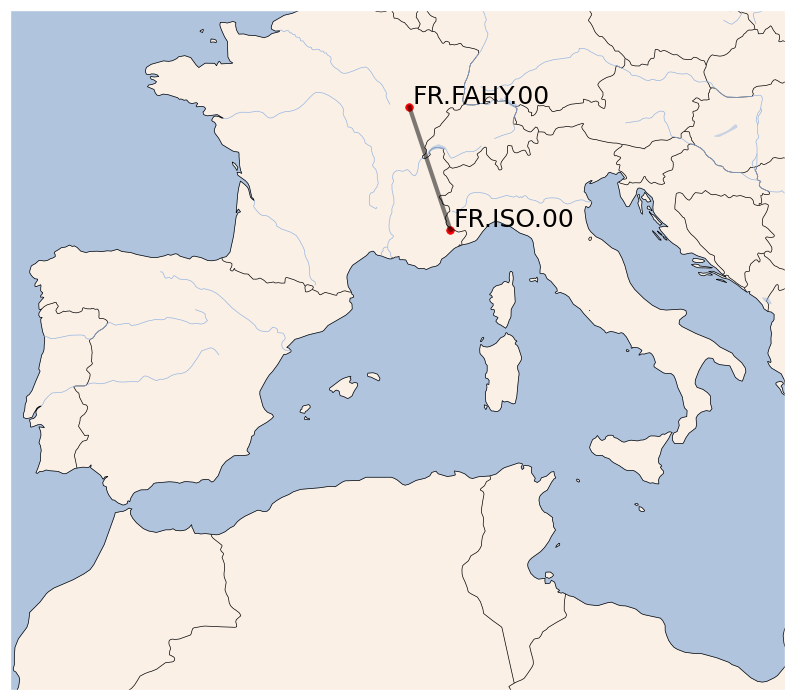

In [8]:
## Station Pairs Metadata
df = pd.read_csv('stations_pair.txt', sep=',', header=None, index_col=False, names=['idA', 'idB', 'latA', 'latB', 'lonA', 'lonB'], dtype={'idA':str, 'idB':str, 'latA':float, 'latB':float, 'lonA':float, 'lonB':float}, engine='python')
# ## Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAND, color='linen', zorder=0)
ax.add_feature(cfeature.OCEAN, color='lightsteelblue', zorder=0)
for i in range(len(df)):
    ax.annotate(df.idA[i], (df.lonA[i]+0.1, df.latA[i]+0.1), transform = ccrs.PlateCarree(), family = 'sans-serif')
    ax.annotate(df.idB[i], (df.lonB[i]+0.1, df.latB[i]+0.1), transform = ccrs.PlateCarree(), family = 'sans-serif')
    ax.plot((df.lonA[i], df.lonB[i]),(df.latA[i], df.latB[i]), transform = ccrs.PlateCarree(), color='k', alpha=0.5, linewidth=3)
df.plot.scatter(x='lonA', y='latA', s=30, ax=ax, c='r', transform = ccrs.PlateCarree())
df.plot.scatter(x='lonB', y='latB', s=30, ax=ax, c='r', transform = ccrs.PlateCarree())
plt.show()

## Dates 

In [9]:
## Dates
start = datetime(2020, 9, 25, 0, 0, 0)
end = datetime(2020, 9, 29, 0, 0, 0)

dates = pd.date_range(start, end, freq='3H')

dates_vector = create_date_vect(dates)

## Open WAVEWATCHIII Equivalent Force Amplitude

In [10]:
## Open Model
path_model = '../../ocean_source/pr_oceanswell/rayleigh/F/'

## Open Syngine Archive 

In [11]:
## Open GF archive info
fe , freq, time, distance, spectrum_synth, _ = open_archive(h5_name_spectrum='./synthetics_iasp91_2s_Z_spectrum.h5', h5_name_waveforms='./synthetics_iasp91_2s_Z_waveforms.h5')
N_time = len(time)

## Synthetic Cross-correlation Computation

./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092500.nc already computed


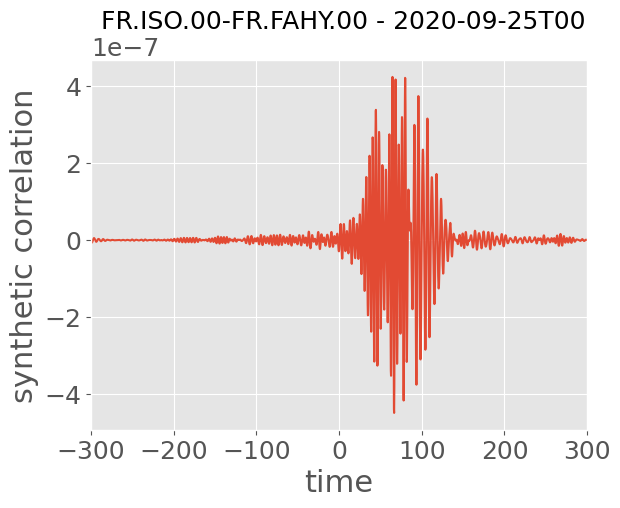

4.4928839176140857e-07
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092503.nc already computed


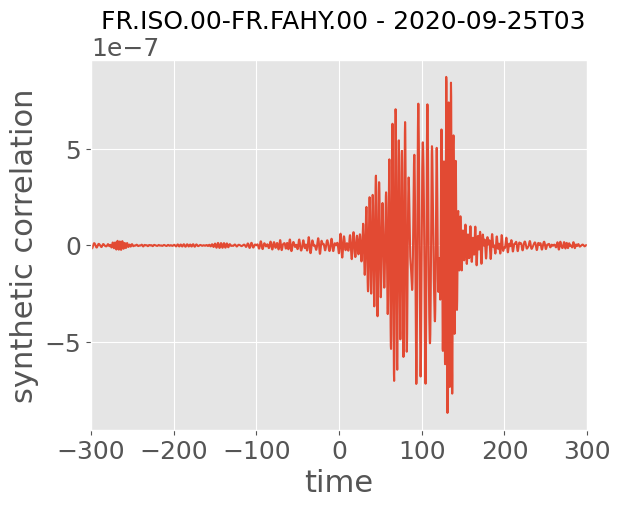

8.738390909377229e-07
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092506.nc already computed


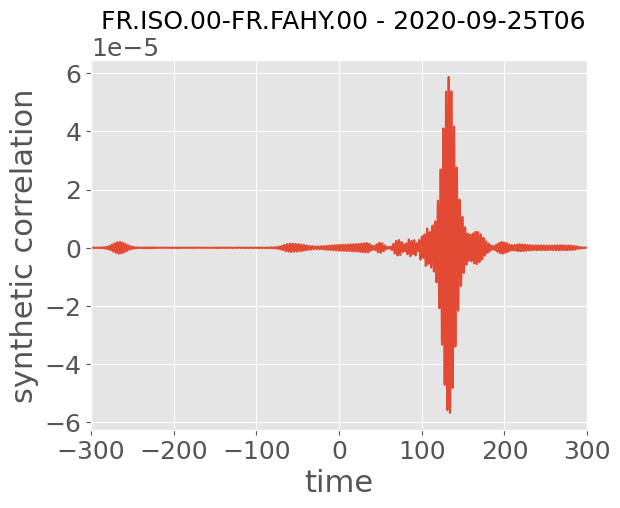

5.8705348909237176e-05
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092509.nc already computed


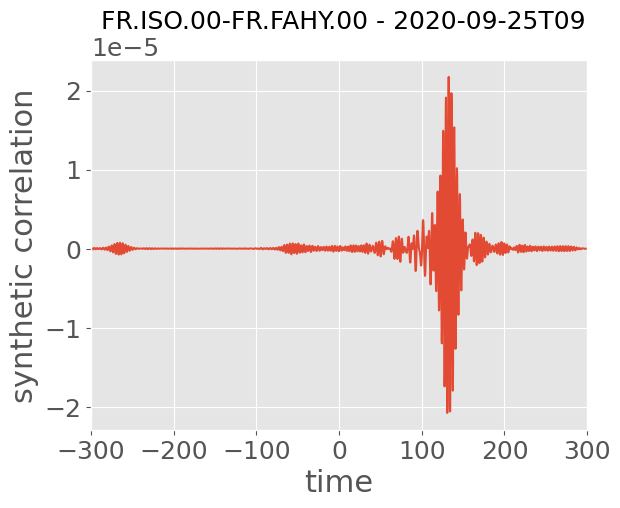

2.1727394741876648e-05
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092512.nc already computed


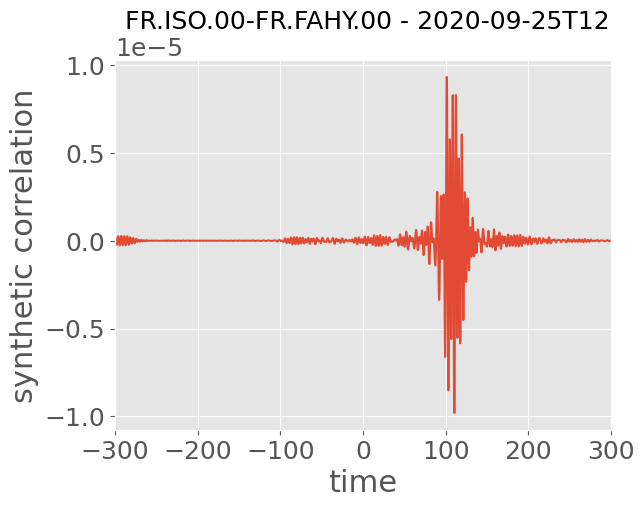

9.798720002038694e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092515.nc already computed


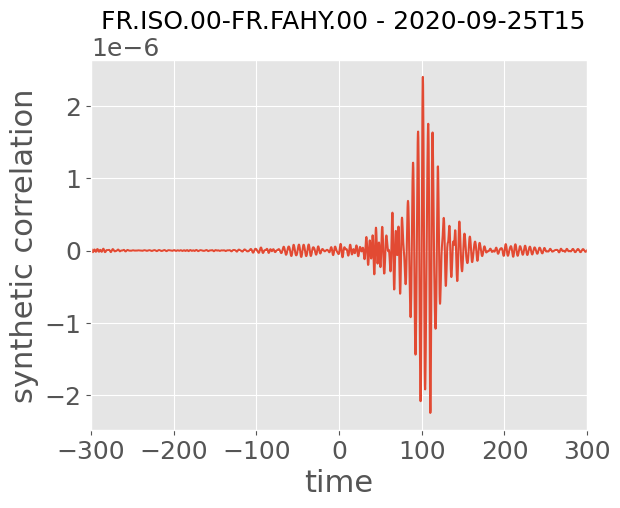

2.398923232660854e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092518.nc already computed


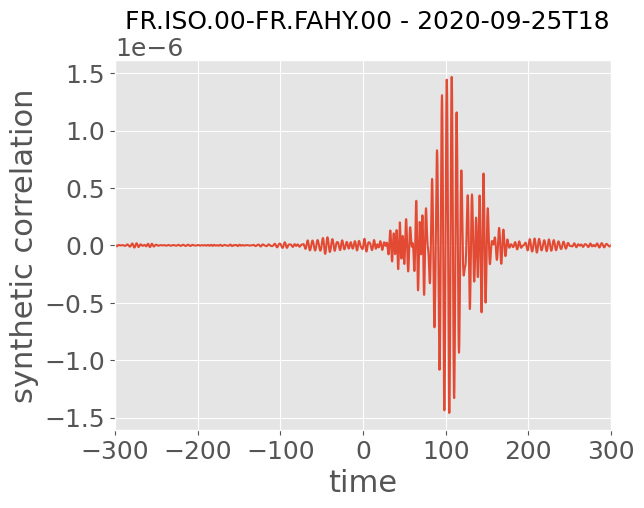

1.4665943877156305e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092521.nc already computed


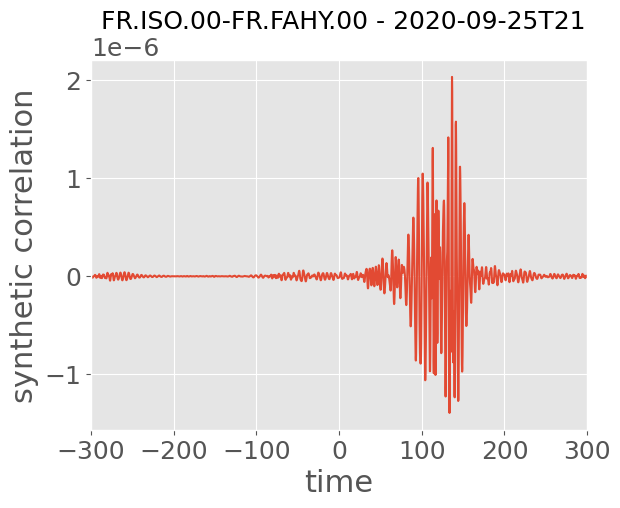

2.030854387939558e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092600.nc already computed


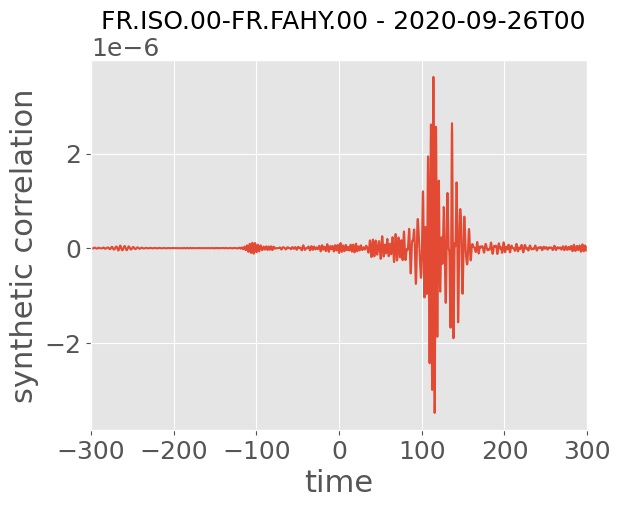

3.6207106592676515e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092603.nc already computed


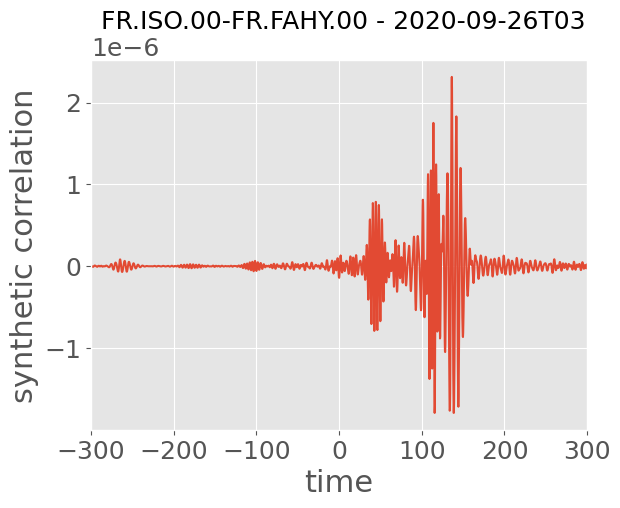

2.31293472617388e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092606.nc already computed


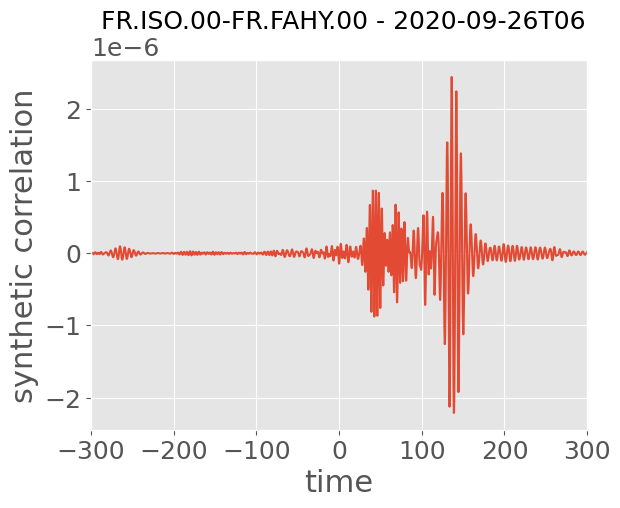

2.4432676986208988e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092609.nc already computed


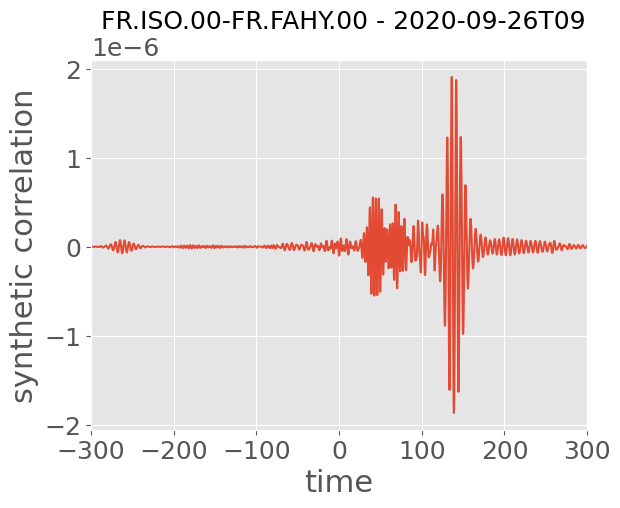

1.9080781583867194e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092612.nc already computed


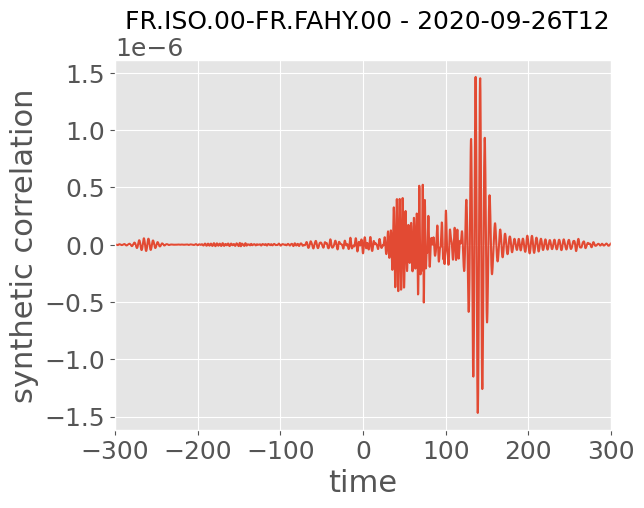

1.4678283389723206e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092615.nc already computed


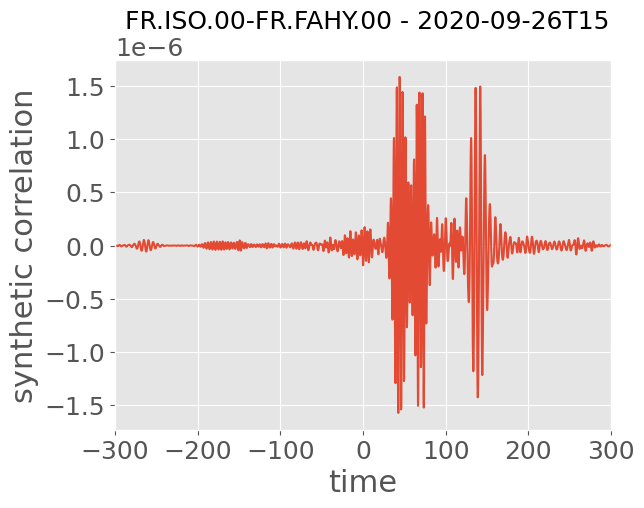

1.583871859926768e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092618.nc already computed


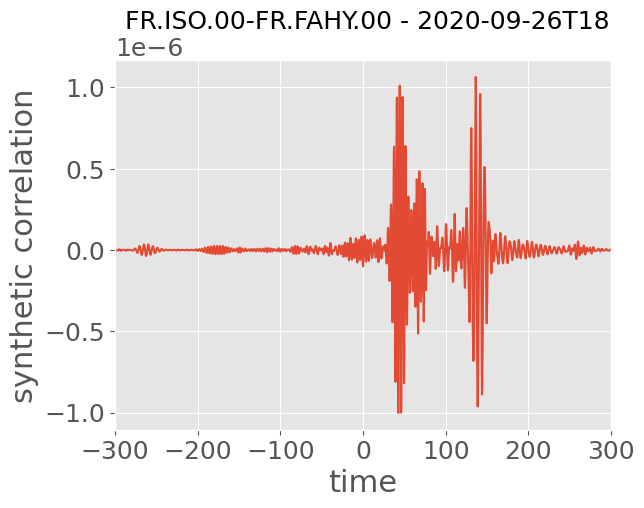

1.0649669432415397e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092621.nc already computed


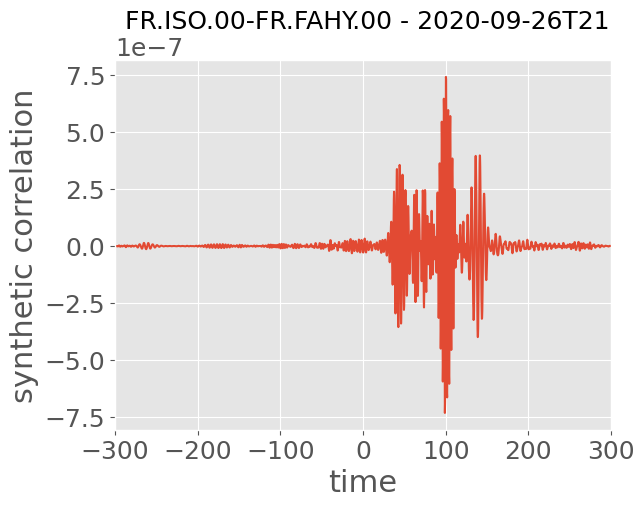

7.413452086770463e-07
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092700.nc already computed


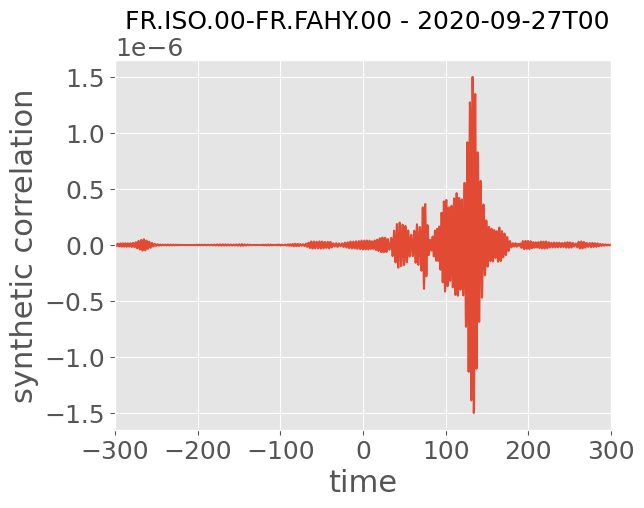

1.5034703544638133e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092703.nc already computed


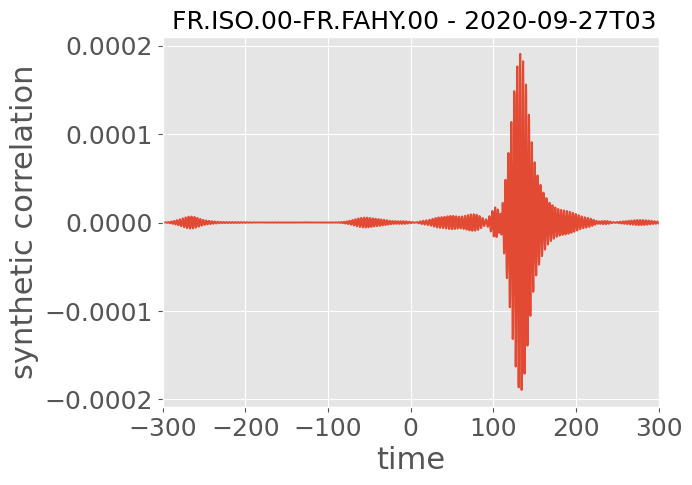

0.0001906362820298483
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092706.nc already computed


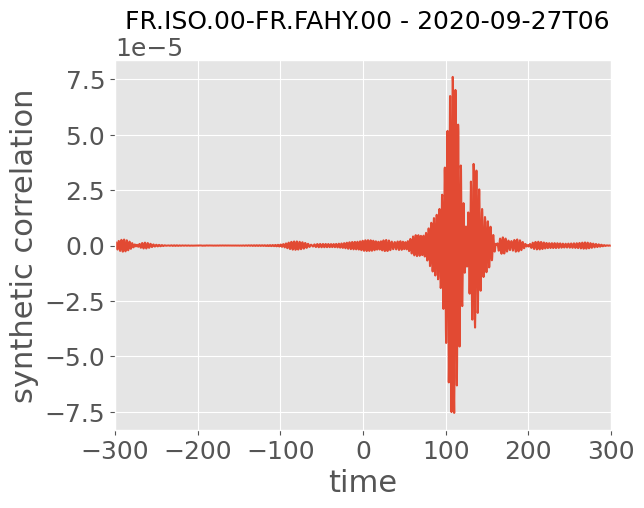

7.609025187658442e-05
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092709.nc already computed


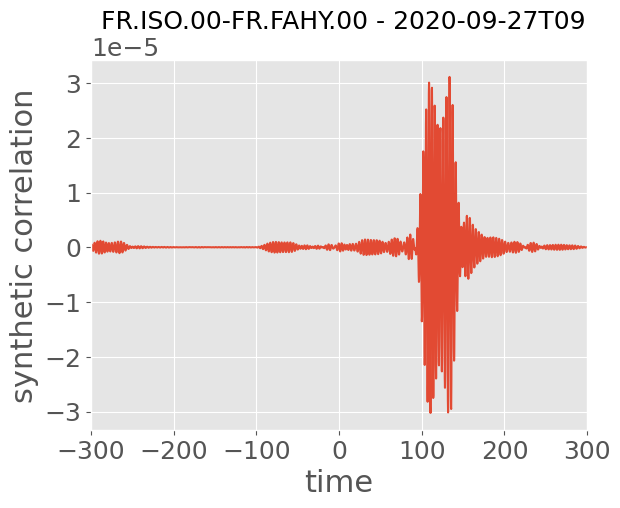

3.1110811531220884e-05
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092712.nc already computed


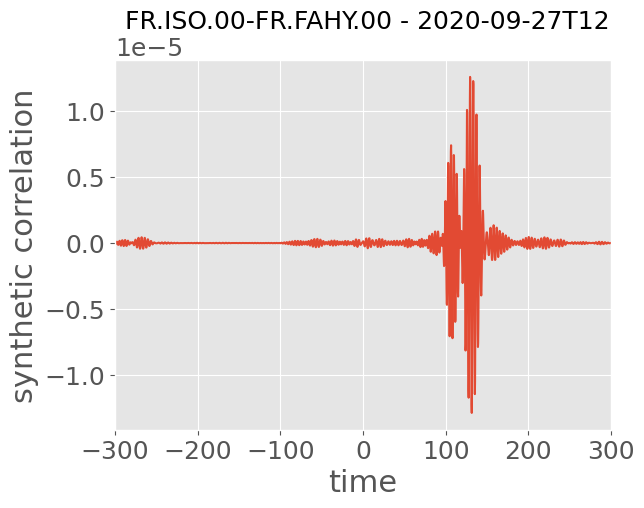

1.2897918219883034e-05
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092715.nc already computed


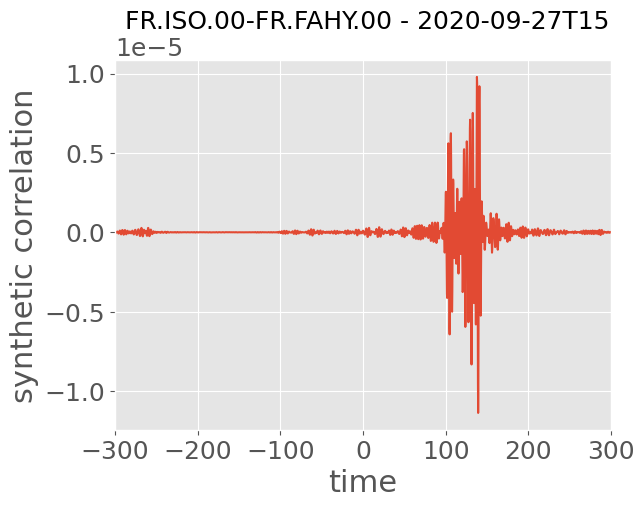

1.1376397055870927e-05
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092718.nc already computed


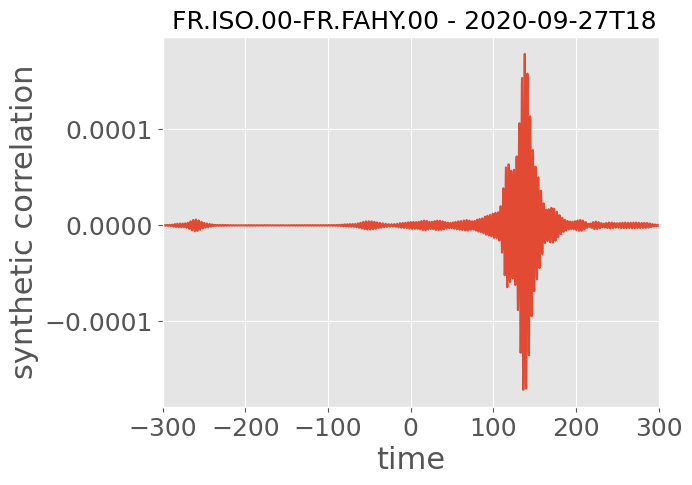

0.00017871170601587347
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092721.nc already computed


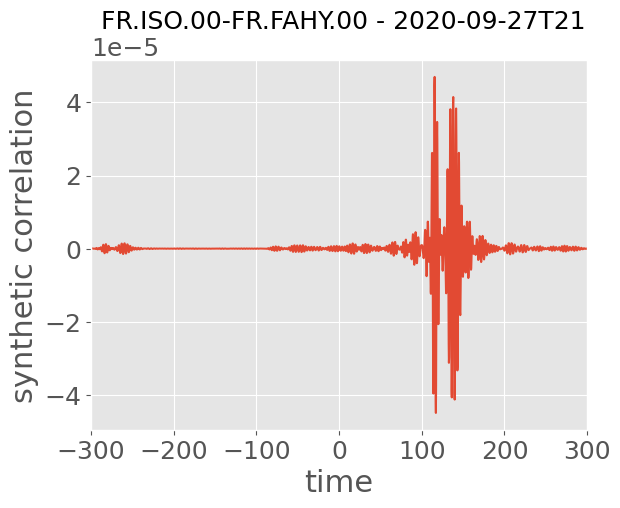

4.6980311997207855e-05
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092800.nc already computed


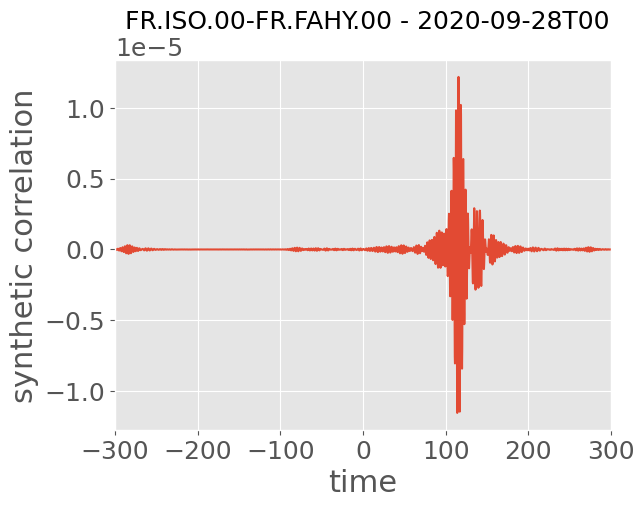

1.2175378014378191e-05
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092803.nc already computed


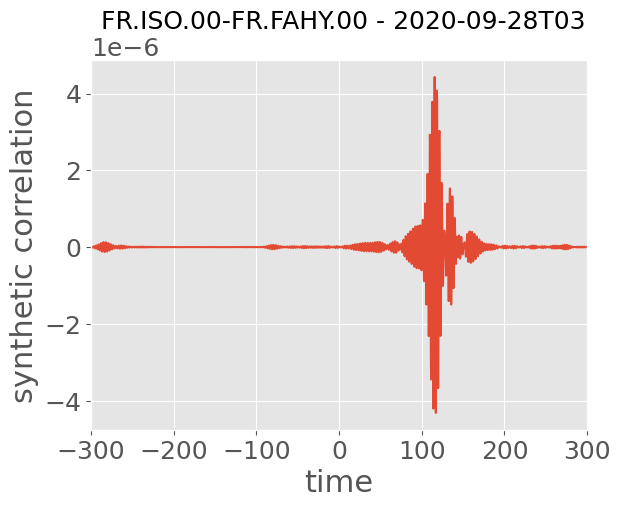

4.433237530196237e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092806.nc already computed


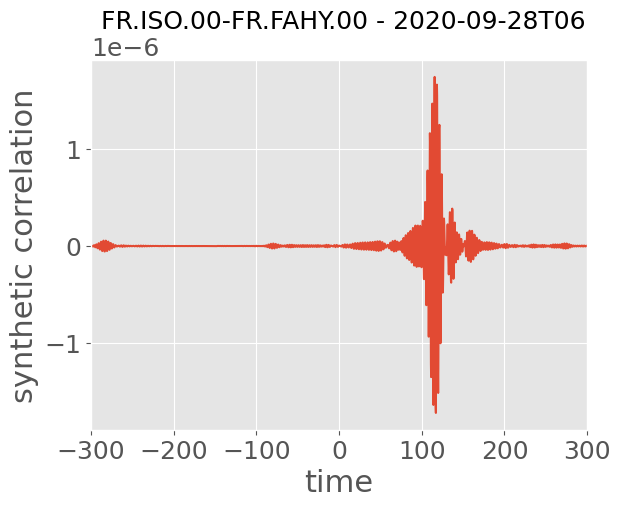

1.7402680016772606e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092809.nc already computed


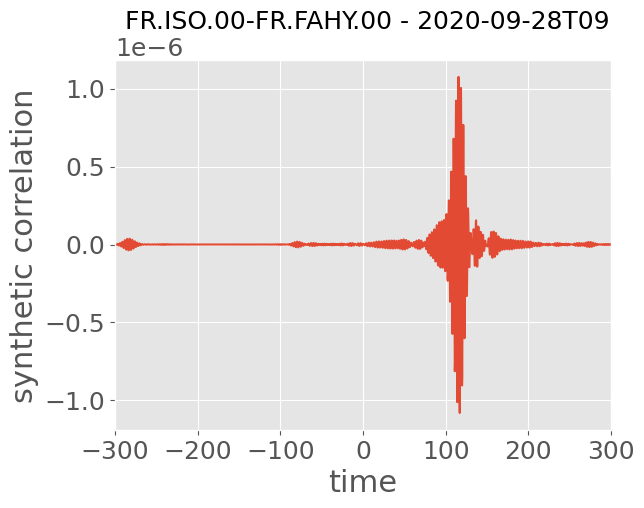

1.0799110474336753e-06
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092812.nc already computed


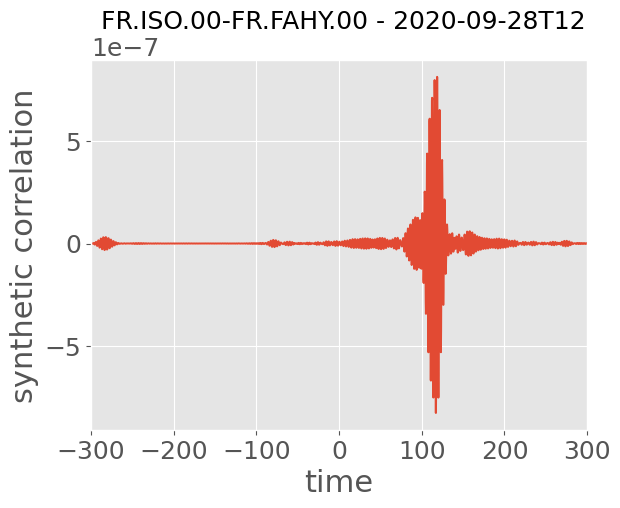

8.233031674711681e-07
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092815.nc already computed


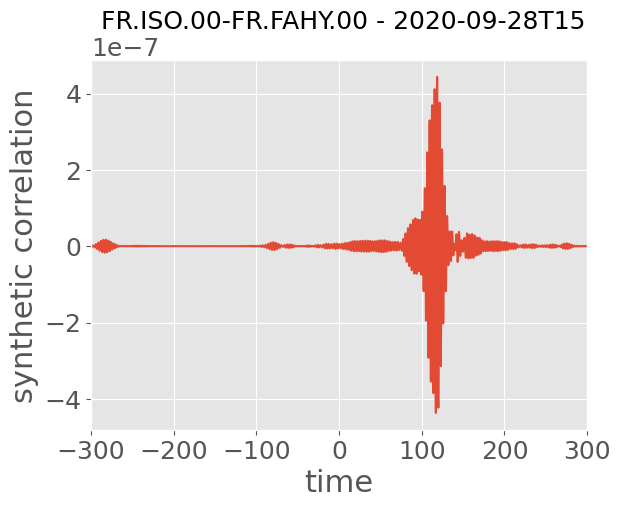

4.4356477118003937e-07
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092818.nc already computed


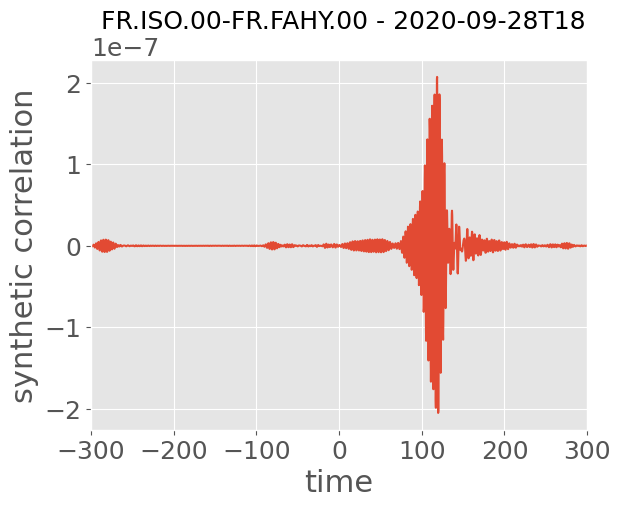

2.074237811248214e-07
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092821.nc already computed


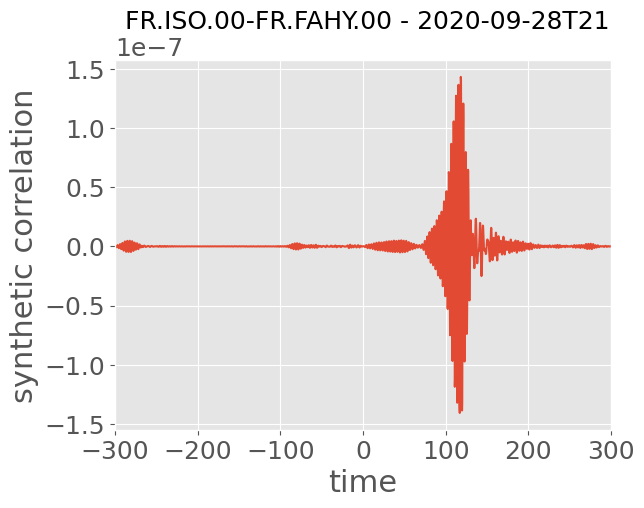

1.4332765044434414e-07
./CCF/ccf_FR.ISO.00_FR.FAHY.00_2020092900.nc already computed


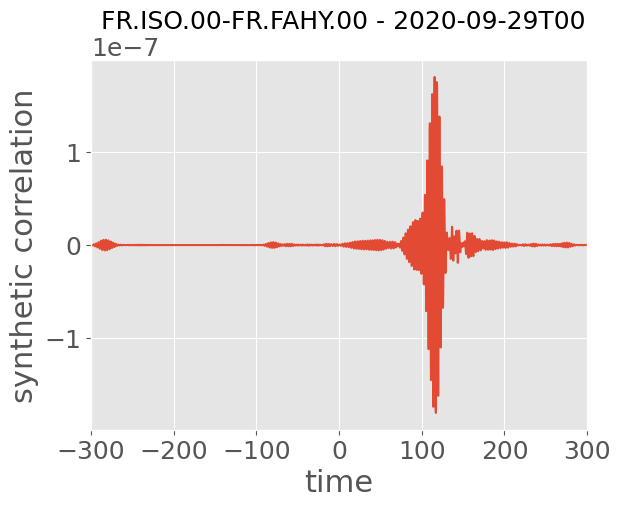

1.808362041009054e-07


In [12]:
## Compute CCF and save it
### Station Pair Info
id_A = df.idA[0]
id_B = df.idB[0]
coords_staA = (df.lonA[0], df.latA[0])
coords_staB = (df.lonB[0], df.latB[0])

#### Keep Correlations
corr_3h = np.zeros((len(dates_vector), N_time))

### Date Info
for i, date_vect in enumerate(dates_vector):
    ### CCF
    filename_ccf = './CCF/ccf_%s_%s_%d%02d%02d%02d.nc'%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]) # File Name Understandable

    if os.path.exists(filename_ccf):  # Check if file already exists
        print('%s already computed'%filename_ccf)
        corr = xr.open_dataarray(filename_ccf)
    else:  # if not, compute CCF
        t1 = ttime.perf_counter()
        corr, time_corr = ccf_computation(coords_staA, coords_staB, path_model, date_vect, spectrum_synth,extent=extent, fe=fe, N=N_time, comp='Z')
        t2 = ttime.perf_counter()
        print(" Time for station pair: ", id_A, id_B, " elapsed: ", t2-t1)
        try:
            corr.to_netcdf('./CCF/ccf_%s_%s_%d%02d%02d%02d.nc'%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]))
        except:
            print("make directory")
            os.mkdir('./CCF')
            corr.to_netcdf('./CCF/ccf_%s_%s_%d%02d%02d%02d.nc'%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]))
    ## Plot CCF
    corr.plot()
    plt.xlim(-300, 300)
    plt.title(" %s-%s - %d-%02d-%02dT%02d"%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]))
    plt.show()
    
    corr_3h[i, :] = corr.values/np.max(abs(corr.values))
    print(np.max(abs(corr.values)))

## Plot

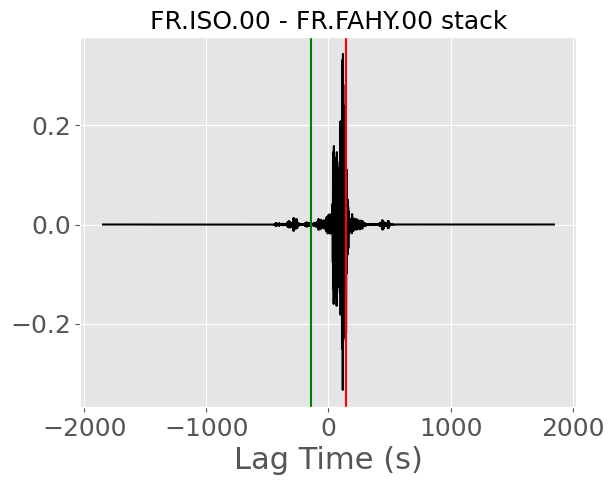

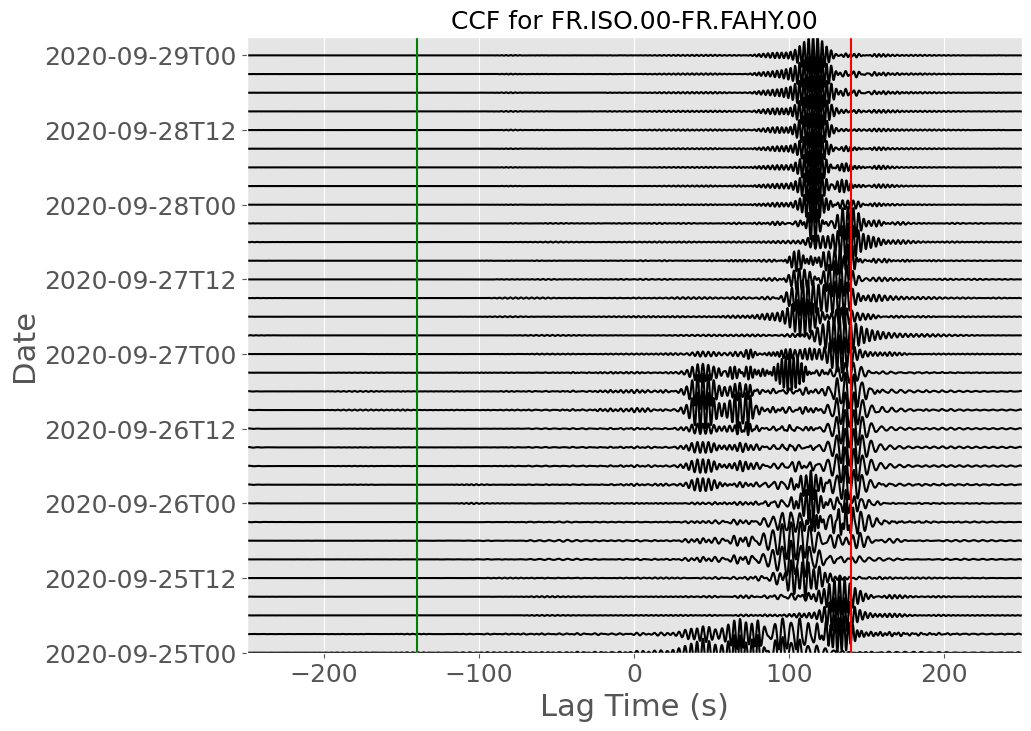

In [13]:
## Plot stack 

plt.figure()
plt.plot(corr.time, np.mean(corr_3h, axis=0), 'k')
plt.axvline(x=140, color='r')
plt.axvline(x=-140, color='g')
# plt.xlim(-250, 250)
plt.xlabel('Lag Time (s)')
plt.title('%s - %s stack'%(id_A, id_B))
plt.show()

## Plot CCF
normalize = np.max(abs(corr_3h))

fig, ax = plt.subplots(figsize=(10,8))
im = ax.plot(corr.time, corr_3h.T/normalize + np.arange(len(dates_vector)), 'k') #, extent=[-300, 300, 0, len(dates_vector)], aspect='auto', cmap='RdYlGn')
ax.set_xlabel('Lag Time (s)')
ax.set_ylabel('Date')
ax.set_title('CCF for %s-%s'%(id_A, id_B))
ax.set_xlim(-250, 250)
ax.set_ylim(0, len(dates_vector))
ax.set_yticks(np.arange(len(dates_vector))[::4])
ax.set_yticklabels(dates[::4].strftime('%Y-%m-%dT%H'))
plt.axvline(x=140, color='r')
plt.axvline(x=-140, color='g')
#fig.colorbar(im, ax=ax)
plt.show()